# Aggregate tool statistics using Atla's data API

## ⚙️ Setup

Ensure that you have required dependencies installed:

```bash
uv pip install pandas matplotlib numpy python-dotenv atla-insights>=0.0.25
```

In [ ]:
from atla_insights.client import Client
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv()   

In [66]:
client = Client(api_key=ATLA_INSIGHTS_API_KEY)

## 🚜 Get traces

In [67]:
traces_list = client.list_traces(page_size=1000)
trace_ids = [trace.id for trace in traces_list.traces]
traces_response = client.get_traces(trace_ids)

## 🦅 Get spans

In [68]:
spans = [span.model_dump() for trace in traces_response.traces for span in trace.spans]
spans = pd.DataFrame(spans).set_index("id")

In [69]:
spans["start_timestamp"] = pd.to_datetime(spans["start_timestamp"])
spans["end_timestamp"] = pd.to_datetime(spans["end_timestamp"])
spans["duration"] = spans["end_timestamp"] - spans["start_timestamp"]

spans["kind"] = spans["attributes"].apply(lambda x: x.get("openinference.span.kind"))
spans["tool_name"] = spans["attributes"].apply(lambda x: x.get("tool.name"))

## 📊 Stats

### ⏱️ Tool call durations

tool_name
think                      0.010000
analyze                    0.003333
set_shared_context         0.002833
transfer_task_to_member    0.000972
Name: Mean duration (seconds), dtype: float64

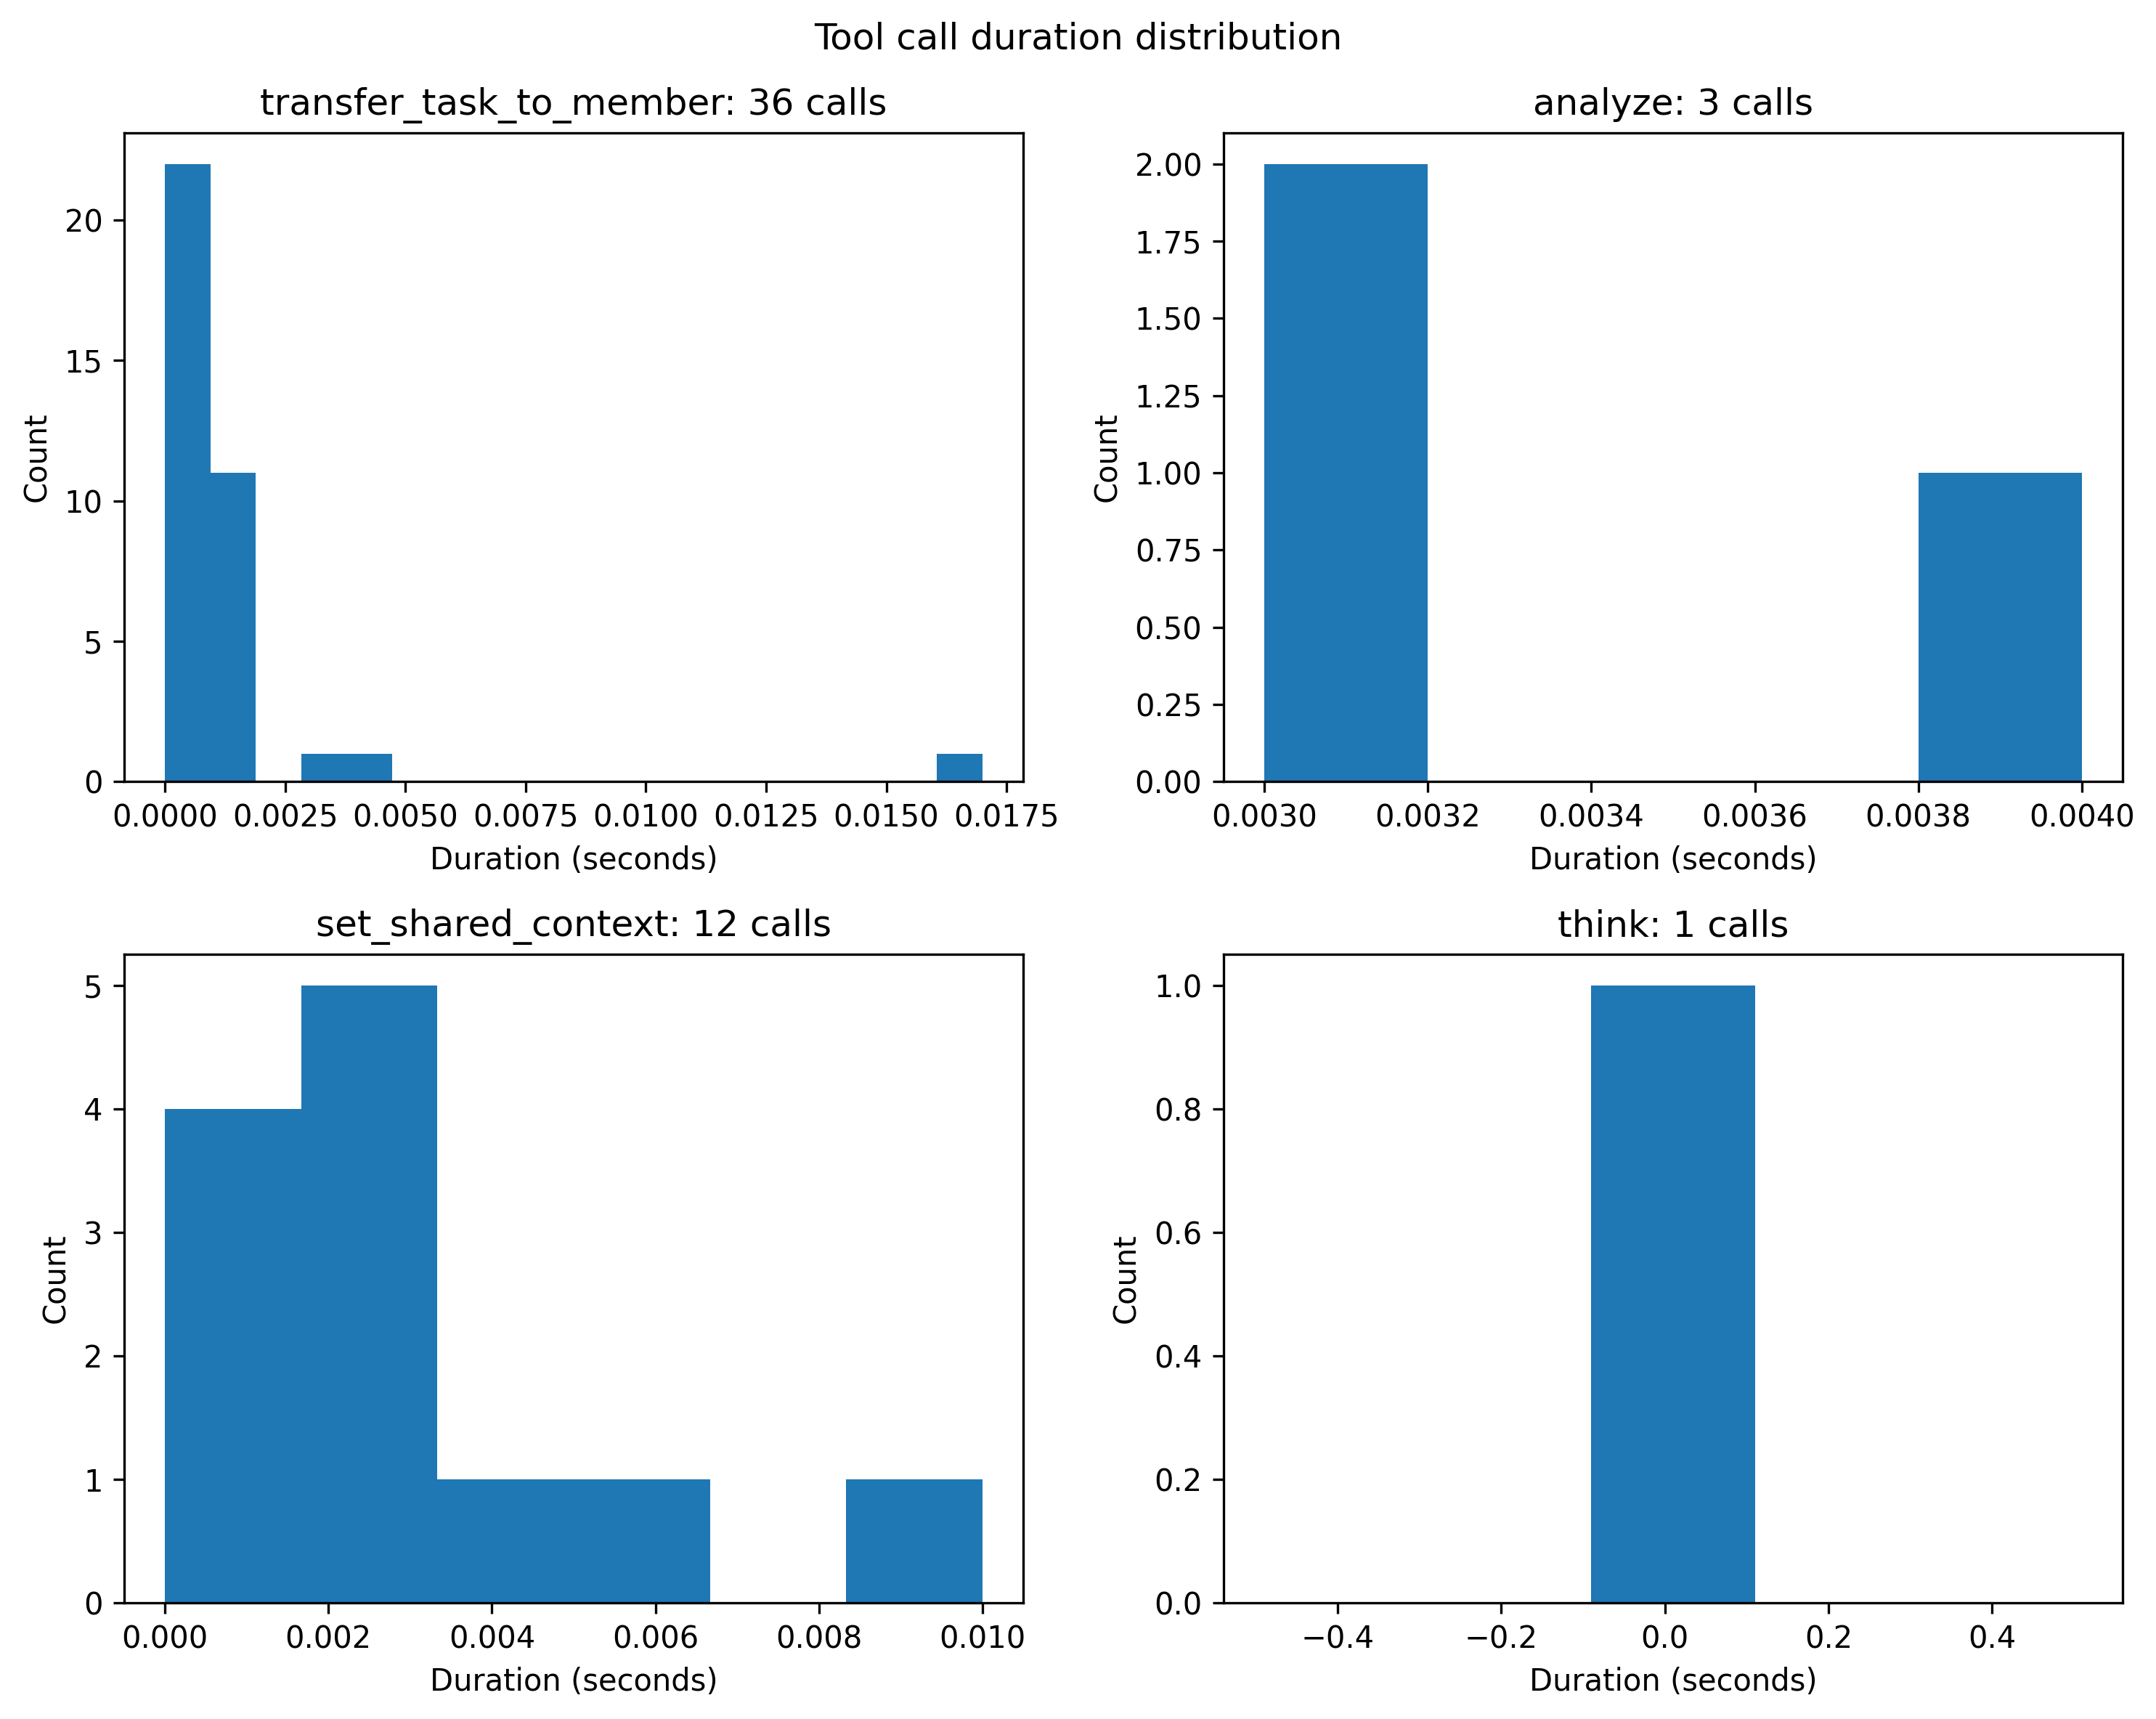

In [ ]:
unique_tool_names = spans[spans["kind"] == "TOOL"]["tool_name"].unique()

n_total = len(unique_tool_names)
n_cols = int(np.ceil(np.sqrt(n_total)))
n_rows = int(np.ceil(n_total / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4), dpi=300, tight_layout=True)
axes = axes.flatten()

for idx, tool_name in enumerate(unique_tool_names):
    tool_spans = spans[spans["tool_name"] == tool_name]
    n_bins = max(min(20, len(tool_spans) // 2), 5)

    tool_spans["duration"].dt.total_seconds().plot.hist(ax=axes[idx], bins=n_bins)
    axes[idx].set_title(f"{tool_name}: {len(tool_spans)} calls")
    axes[idx].set_xlabel("Duration (seconds)")
    axes[idx].set_ylabel("Count")

for idx in range(n_total, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle("Tool call duration distribution")

# Get average figures per tool call
spans[spans["kind"] == "TOOL"].groupby("tool_name")["duration"].mean().dt.total_seconds().rename("Mean duration (seconds)").sort_values(ascending=False)

### 💯 Token counts

Limitations:
- This method calculates the tokens used in completions where a tool is called, including any other output messages and reasoning tokens. It does not calculate the tokens required specifically for generating the tool call arguments.
  - If one would like this information specifically, one could approximate it by retrieving the following keys from the `attributes` fields and tokenising them manually (filling in `X` and `Y` for all present integers):
    - `llm.output_messages.X.message.tool_calls.Y.tool_call.function.name`
    - `llm.output_messages.X.message.tool_calls.Y.tool_call.function.arguments`
- This method treats each completion as if it calls only one tool - though it can call multiple. In fact there are three completions that do 2 tool calls, though these are the same type of tool.
  - To calculate more specific details, one would need to stratify by the individual `llm.output_messages.X.message.tool_calls.Y.tool_call.function.name` attributes.

In [71]:
def get_token_count_stats(attributes) -> dict[str, int | None]:
    return {
        "tool_name": attributes.get("llm.output_messages.0.message.tool_calls.0.tool_call.function.name"),
        "total": attributes.get("llm.token_count.total"),
        "prompt": attributes.get("llm.token_count.prompt"),
        "completion": attributes.get("llm.token_count.completion"),
        "cached_prompt": attributes.get("llm.token_count.prompt_details.cache_read"),
        "reasoning_completion": attributes.get("llm.token_count.completion_details.reasoning"),
    }


token_count_stats = spans[spans["kind"] == "LLM"]["attributes"].apply(get_token_count_stats).apply(pd.Series)
token_count_stats = token_count_stats.dropna(subset=["tool_name"]).dropna(how="all")
token_count_stats["uncached_prompt"] = token_count_stats["prompt"] - token_count_stats["cached_prompt"]
token_count_stats["non_reasoning_completion"] = token_count_stats["completion"] - token_count_stats["reasoning_completion"]

total                    prompt               \
                                 mean          std         mean          std   
tool_name                                                                      
analyze                  11279.666667  1831.574550  9518.333333   356.484689   
set_shared_context       10154.166667  2032.742699  8072.333333  1523.416336   
think                    11341.000000          NaN  9169.000000          NaN   
transfer_task_to_member   9369.222222   495.784675  8218.111111   205.234283   

                         completion              
                               mean         std  
tool_name                                        
analyze                   88.333333   35.697806  
set_shared_context       349.250000  211.558341  
think                    129.000000         NaN  
transfer_task_to_member  688.000000  341.041786

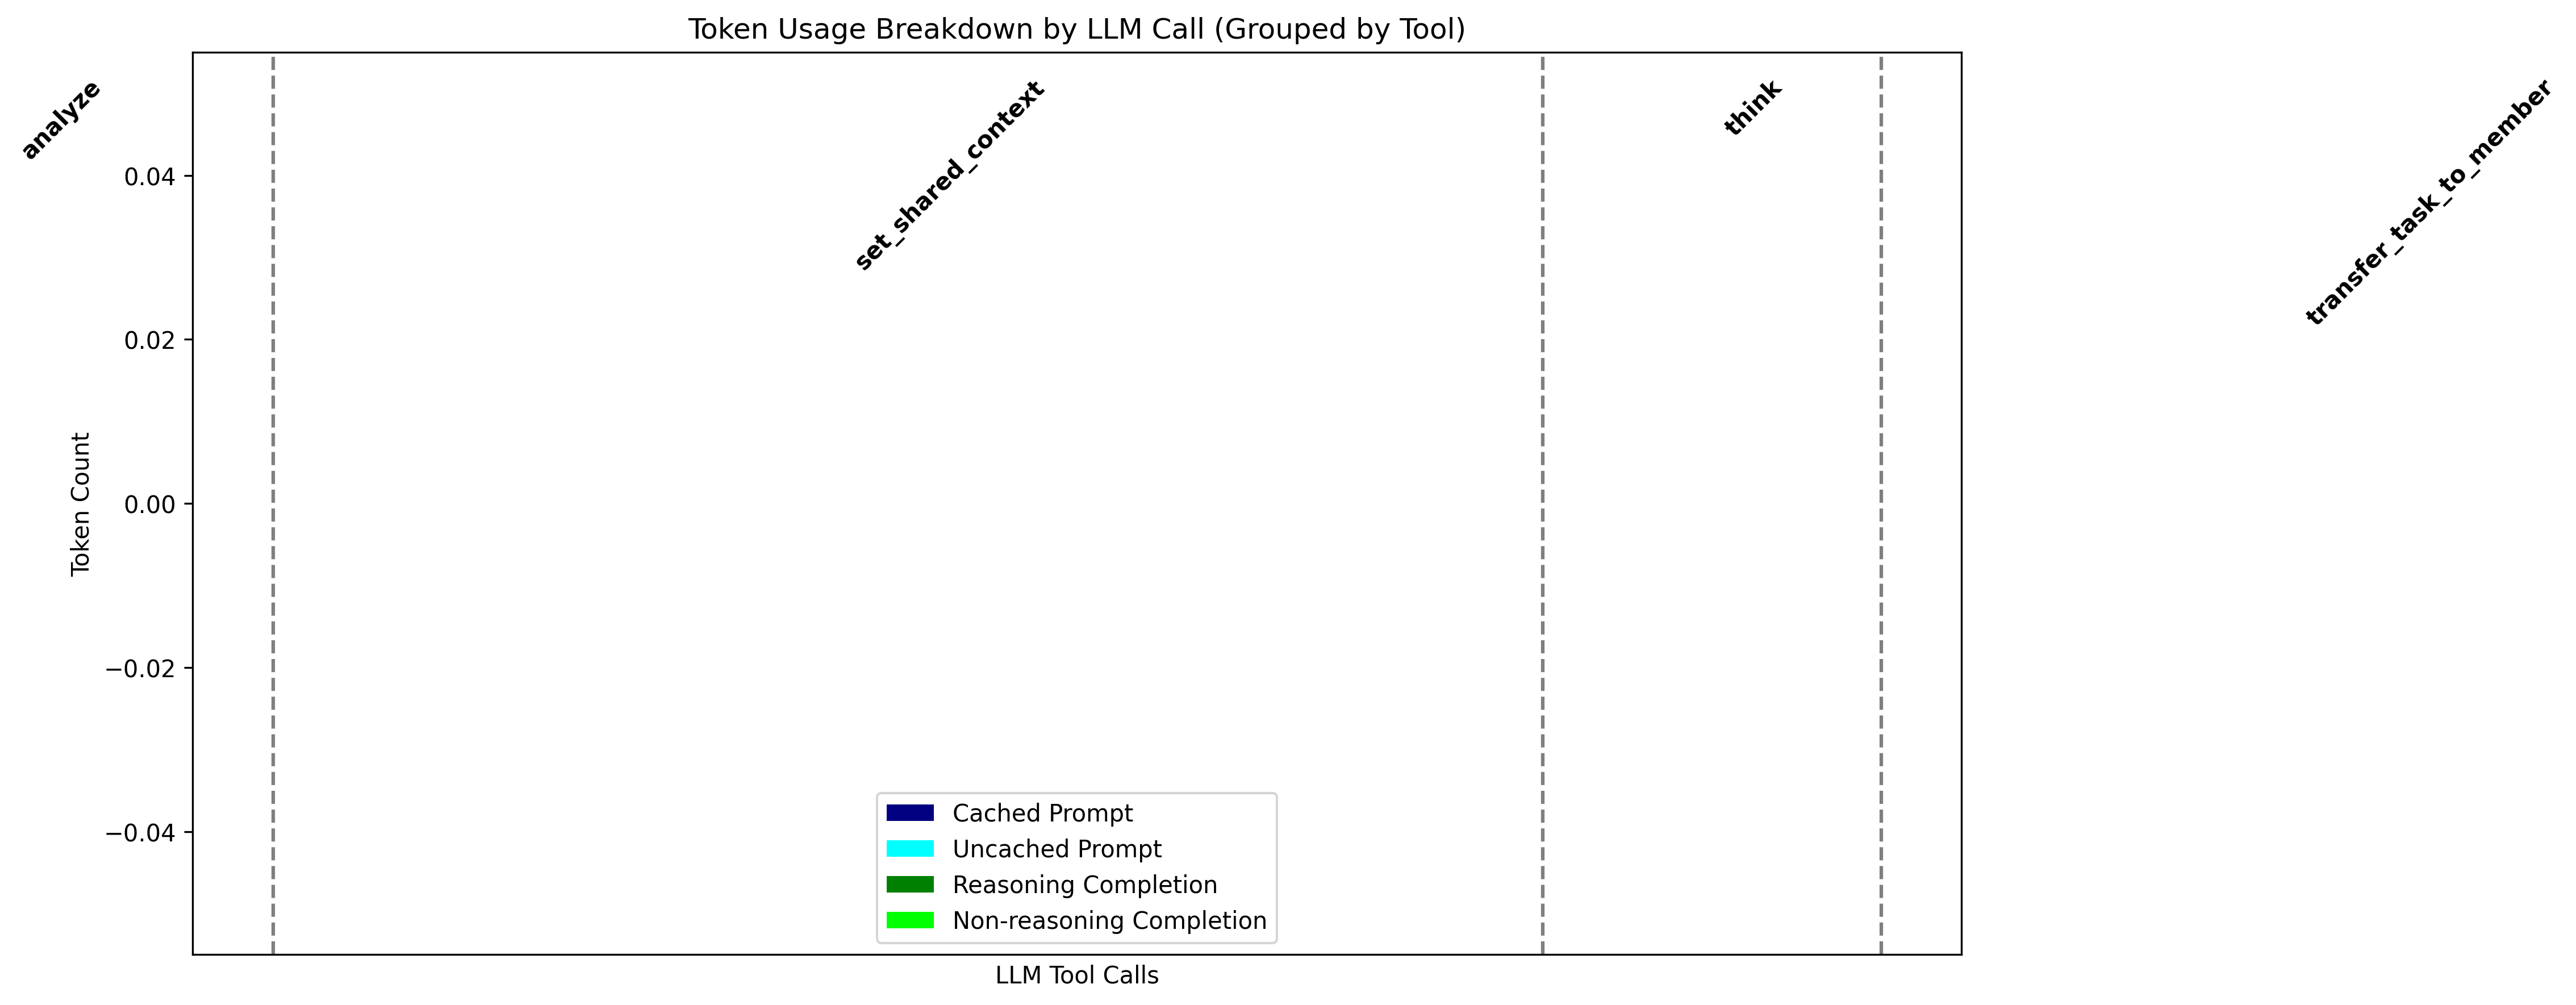

In [72]:
fig, axis = plt.subplots(figsize=(15, 6), dpi=300, tight_layout=True)

token_count_stats = token_count_stats.sort_values(["tool_name", "total"], ascending=[False, True])
grouped_data = token_count_stats.groupby('tool_name')

x_pos = []
group_positions = []
current_pos = 0
for tool_name, group in grouped_data:
    group_start = current_pos
    for i, (idx, row) in enumerate(group.iterrows()):
        x_pos.append(current_pos)
        current_pos += 1
    group_positions.append((group_start, current_pos - 1, tool_name))
    current_pos += 3

bars1 = axis.bar(x_pos[::-1], token_count_stats['cached_prompt'], color='navy', label='Cached Prompt')
bars2 = axis.bar(x_pos[::-1], token_count_stats['uncached_prompt'], bottom=token_count_stats['cached_prompt'], color='cyan', label='Uncached Prompt')
bars3 = axis.bar(x_pos[::-1], token_count_stats['reasoning_completion'], bottom=token_count_stats['cached_prompt'] + token_count_stats['uncached_prompt'], color='green', label='Reasoning Completion')
bars4 = axis.bar(x_pos[::-1], token_count_stats['non_reasoning_completion'], bottom=token_count_stats['cached_prompt'] + token_count_stats['uncached_prompt'] + token_count_stats['reasoning_completion'], color='#00FF00', label='Non-reasoning Completion')

for i, (start, end, tool_name) in enumerate(group_positions[:-1]):
    axis.axvline(x=end + 1.5, color='black', linestyle='--', alpha=0.5)

for start, end, tool_name in group_positions:
    center_pos = (start + end) / 2
    axis.text(center_pos, axis.get_ylim()[1] * 0.95, tool_name,
            ha='center', va='top', fontweight='bold', rotation=45)

axis.set_xticks([])
axis.set_xlabel('LLM Tool Calls')
axis.set_ylabel('Token Count')
axis.set_title('Token Usage Breakdown by LLM Call (Grouped by Tool)')
axis.legend()

token_count_stats.groupby("tool_name").agg({"total": ["mean", "std"], "prompt": ["mean", "std"], "completion": ["mean", "std"]})